## Deep Learning

## Traffic Sign Recognition Classifier

### Udacity Self-Driving Car Engineer Nanodegree

The was the second project in the self-driving car program. The code base was provided as a template for the project. 

The [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) was used for this project

### Dataset Exploration

The pickled data is a dictionary with 4 key/value pairs:

#### Read in data from pickle file

In [1]:
#### Docker was used before TensorFlow was available on Windows
# '''
# $ docker run -it --rm -p 8888:8888 -v ${pwd}/TensorExample:/notebooks udacity/carnd-tensorflow-lab
# '''

# Load pickled data
%matplotlib inline
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import random
import os
import time
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from IPython.display import HTML

# TODO: fill this in based on where you saved the training and testing data
training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train.shape

# TODO: how many classes are in the dataset
n_classes = len(set(train['labels']))
n_input = image_shape[1]*image_shape[2] 

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


The following tutorial was used to plot images and save tf session.
https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/04_Save_Restore.ipynb


In [3]:
def plot_images(images, cls_true, img_shape, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.savefig("Signs_labels.jpg")
    plt.show()
#     plt.savefig("Signs_labels.png")

### Plot some images with labels

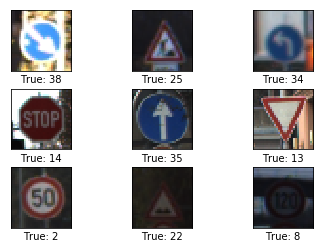

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.\

sample = random.sample(range(len(X_test)), 9)
s_images = [ X_test[i] for i in sample]
s_labels =  [ y_test[i] for i in sample]

img_clr = (image_shape[1],image_shape[2],image_shape[3])
plot_images(images=s_images, cls_true=s_labels, img_shape = img_clr)

In [5]:
def plot_images_grey(images, cls_true, img_shape, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i], cmap='gray')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

----

### Develop Model Architecture


In [6]:
# preprocess data

def grayImg(X):

    features = []
    labels = []
    
    # Convert to grayscale
    X = np.mean(X, axis=3,dtype=int)
    return np.array(X)

# min max scaling
def normalize_grayscale(image_data):
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

def oneHot(labels):
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer() # very useful function
    encoder.fit(labels)
    labels = encoder.transform(labels)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    return labels.astype(np.float32)
   

X_trainG = grayImg(X_train)
X_testG = grayImg(X_test)

train_features = normalize_grayscale(X_trainG)
test_features = normalize_grayscale(X_testG)
    
# test_features = np.reshape(test_features,[-1, n_input]) 

train_features = train_features.astype(np.float32)
test_features = test_features.astype(np.float32)

# one hot encode labels
train_labels = oneHot(y_train)
test_labels = oneHot(y_test)

print("...Preprocessing Complete")


...Preprocessing Complete


### Display Preprocessed Images

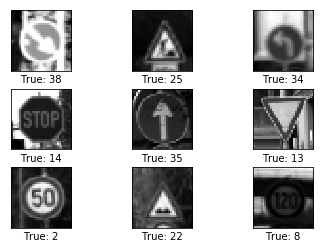

In [7]:

s_images = [ test_features[i] for i in sample]
s_labels =  [ y_test[i] for i in sample]

img_blk = (image_shape[1],image_shape[2])
plot_images_grey(images=s_images, cls_true=s_labels,img_shape=img_blk)


The data was converted to grayscale to increase processing speed with similar final results. The Data was also normalized to values between .1 and .9 to avoid numerical errors and increase processing speed. The randomly sampled, greyscaled, and normalized images were ploted and can be compared to the randomply sampled rgb images ploted above.

### Generate Training and Validation Data

In [8]:


train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('train_features', train_features.shape)
print('valid_features', valid_features.shape)
print('train_labels', train_labels.shape)
print('Training features and labels randomized and split.')

train_features (37248, 32, 32)
valid_features (1961, 32, 32)
train_labels (37248, 43)
Training features and labels randomized and split.


The training data was split up into a validation set and a training set with 5% of the data going into the validation set. The validation set will be used to verify the performance of the optimization iterations and to determine if sufficient training has been done. The test set which was originally imported also remains and will remain untouched until training is complete. This will avoid the tendency to let the test data information creep into the training parameters.

In [9]:

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.



In [10]:
img_size = 32

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 43



In [11]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [12]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [13]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [14]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [15]:

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

Flatten Features for tf optimizer

In [16]:
x_flat = np.reshape(train_features, [-1, img_size_flat]).astype(np.float32)
valid_flat = np.reshape(valid_features, [-1, img_size_flat]).astype(np.float32)
test_flat = np.reshape(test_features, [-1, img_size_flat]).astype(np.float32)

In [17]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
#reshape for convolutional network
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

#one hot
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
#label only
y_true_cls = tf.argmax(y_true, dimension=1)

In [18]:
# create Convolutional Layer 1
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
print(layer_conv1)

Tensor("Relu:0", shape=(?, 16, 16, 16), dtype=float32)


In [19]:
# create Convolutional Layer 2
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
print(layer_conv2)

Tensor("Relu_1:0", shape=(?, 8, 8, 36), dtype=float32)


In [20]:
# flatten output of Conv 2 layer to be input to fully connected
layer_flat, num_features = flatten_layer(layer_conv2)
print(layer_flat)
print(num_features)

Tensor("Reshape_1:0", shape=(?, 2304), dtype=float32)
2304


In [21]:
# add fully connected layer
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
print(layer_fc1)

# add second fully connected layer to connect to outputs
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

print(layer_fc2)

Tensor("Relu_2:0", shape=(?, 128), dtype=float32)
Tensor("add_3:0", shape=(?, 43), dtype=float32)


In [22]:
#Predict class
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

# calc cross entropy from output of layer_fc2 directly
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

In [23]:
# calculate accuracy
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# Run TensorFlow

In [24]:
# setup parameters
train_batch_size = 64
learning_rate = 5e-4
#Adam optimizer is an advanced form of Gradient Descent
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Best validation accuracy seen so far.
best_validation_accuracy = 0.0

# Iteration-number for last improvement to validation accuracy.
last_improvement = 0

# Stop optimization if no improvement found in this many iterations.
require_improvement = 2000


Create saver function

In [25]:
saver = tf.train.Saver()
save_dir = 'checkpoints/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = save_dir + 'best_validation'

In [27]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [28]:
# Counter for total number of iterations performed so far.
total_iterations = 0

In [29]:
      
n_train_examples = len(train_features)
total_batch = int(n_train_examples/train_batch_size)+1                
train_feature_batch = np.array_split(x_flat, total_batch)
train_label_batch = np.array_split(train_labels, total_batch)
# Loop over all batches
# for i in range(total_batch):
#     batch_x = train_feature_batch[i] 
#     batch_y = train_label_batch[i]

In [30]:


def optimize(epocs):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    global best_validation_accuracy
    global last_improvement
    
    # Start-time used for printing time-usage below.
    start_time = time.time()

#     for i in range(total_iterations,
#                    total_iterations + num_iterations):
    for n in range(epocs):
        for i in range(total_batch):

            # Update the total number of iterations performed.
            total_iterations += 1      

    #         batch_start = i*train_batch_size

            # Get a batch of training examples.
            # x_batch now holds a batch of images and
            # y_true_batch are the true labels for those images.

            # expects flattened features
    #         x_batch = x_flat[batch_start:batch_start + train_batch_size]
    #         y_true_batch = train_labels[batch_start:batch_start +train_batch_size]

            x_batch = train_feature_batch[i] 
            y_true_batch = train_label_batch[i]


            # Put the batch into a dict with the proper names
            # for placeholder variables in the TensorFlow graph.
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch}

            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            session.run(optimizer, feed_dict=feed_dict_train)


            if (total_iterations % 100 == 0) or (i == (total_batch - 1)):

                # Calculate the accuracy on the training-batch.
                acc_train = session.run(accuracy, feed_dict=feed_dict_train)

                # Calculate the accuracy on the validation-set.
                # The function returns 2 values but we only need the first.
                valid_feed_dict = {x: valid_flat,
                               y_true: valid_labels}
                acc_validation = session.run(accuracy, feed_dict=valid_feed_dict)

                            # If validation accuracy is an improvement over best-known.
                if acc_validation > best_validation_accuracy:
                    # Update the best-known validation accuracy.
                    best_validation_accuracy = acc_validation

                    # Set the iteration for the last improvement to current.
                    last_improvement = total_iterations

                    # Save all variables of the TensorFlow graph to file.
                    saver.save(sess=session, save_path=save_path)

                    # A string to be printed below, shows improvement found.
                    improved_str = '*'
                else:
                    # An empty string to be printed below.
                    # Shows that no improvement was found.
                    improved_str = ''

                # Status-message for printing.
                msg = "Iter: {0:>6}, Train-Batch Accuracy: {1:>6.1%}, Validation Acc: {2:>6.1%} {3}"

                # Print it.
                print(msg.format(i + 1, acc_train, acc_validation, improved_str))

            # If no improvement found in the required number of iterations.
            if total_iterations - last_improvement > require_improvement:
                print("No improvement found in a while, stopping optimization.")

                # Break out from the for-loop.
                break            
            

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [31]:
optimize(epocs=50)

Iter:    100, Train-Batch Accuracy:   4.7%, Validation Acc:   7.3% *
Iter:    200, Train-Batch Accuracy:   6.2%, Validation Acc:  11.1% *
Iter:    300, Train-Batch Accuracy:  31.2%, Validation Acc:  32.7% *
Iter:    400, Train-Batch Accuracy:  48.4%, Validation Acc:  47.4% *
Iter:    500, Train-Batch Accuracy:  78.1%, Validation Acc:  63.0% *
Iter:    583, Train-Batch Accuracy:  68.3%, Validation Acc:  66.0% *
Iter:     17, Train-Batch Accuracy:  68.8%, Validation Acc:  69.7% *
Iter:    117, Train-Batch Accuracy:  71.9%, Validation Acc:  74.9% *
Iter:    217, Train-Batch Accuracy:  84.4%, Validation Acc:  78.9% *
Iter:    317, Train-Batch Accuracy:  87.5%, Validation Acc:  82.9% *
Iter:    417, Train-Batch Accuracy:  92.2%, Validation Acc:  82.5% 
Iter:    517, Train-Batch Accuracy:  87.5%, Validation Acc:  85.2% *
Iter:    583, Train-Batch Accuracy:  81.0%, Validation Acc:  83.6% 
Iter:     34, Train-Batch Accuracy:  92.2%, Validation Acc:  86.3% *
Iter:    134, Train-Batch Accuracy: 

## Get performance on test set
Test set must be split into batches due to its size

In [32]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [33]:
#test_feed_dict = {x: test_flat, y_true: test_labels}

sess = tf.Session()
saver.restore(sess, save_path=save_path)    
#print("test accuracy %g"%accuracy.eval(feed_dict=test_feed_dict,session=sess))

INFO:tensorflow:Restoring parameters from checkpoints/best_validation


In [34]:
def cls_accuracy(correct):
    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / len(correct)

    return acc, correct_sum

In [35]:
# Test data must be split up into batches due to memory constraints
correct, cls_pred = predict_cls(images = test_flat, 
                                labels = test_labels, cls_true = y_test)

test_acc, num_correct = cls_accuracy(correct)
num_images = len(correct)
# Print the accuracy.
msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
print(msg.format(test_acc, num_correct, num_images))



Accuracy on Test-Set: 91.0% (11490 / 12630)


The model chosen was a convolutional neural network described in this tutorial:
https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb

![](arc.png)  

Image Source: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb


The optimizer used was the Adam1 optimizer which is an advanced form of gradient descent. The batch size chosen was 64 for memory constraints. The epochs were chosen to be enough to allow the improvement in accuracy on the validation set to reach its peek. A break function was used if there was not much impovement after 2000 iterations.